In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 0

In [2]:
train_full = pd.read_csv('./data/bulldozer/Train.csv', low_memory=False)
test = pd.read_csv('./data/bulldozer/Valid.csv')
test_solution = pd.read_csv('./data/bulldozer/ValidSolution.csv')

### Data research

fiModelDesc is just the combination of fiBaseModel, fiSecondaryDesc, fiModelSeries, and fiModelDescriptor. Richer information is likely to be extracted when using them individually, so we won't use fiModelDesc.

fiProductClassDesc contains the ProductGroupDesc as well as a descriptor of the "primary size basis" and the range of the size (when present). The size basis and range can be dropped from the product group desc by removing all up to the first " - ". 

ProductGroup is just the ProductGroupDesc abbreviated

Many of the latter columns have "None or Unspecified" listed instead of "blank", where the two seem to be functionally the same. To maintain consistency, we will make "None or Unspecified" blank.

Some of the latter columns have a whole lot of blank data, will have to experiment to see if it useful to keep them.

## Exploration and Cleaning

In [3]:
def clean_data(df: pd.DataFrame):
    data = df.copy()
    data = data.sort_values(by='saledate', ascending=True)

    """
    fiModelDesc is just the combination of fiBaseModel, fiSecondaryDesc, 
    fiModelSeries, and fiModelDescriptor. Richer information is likely to be 
    extracted when using them individually, so we won't use fiModelDesc.
    """
    data = data.drop(['fiModelDesc'], axis=1)

    """
    Many of the latter columns have "None or Unspecified" listed instead of "blank",
    where the two seem to be functionally the same. To maintain consistency, 
    we will make "None or Unspecified" blank.
    """
    data.replace('None or Unspecified', np.nan, inplace=True)

    """
    fiProductClassDesc contains the ProductGroupDesc as well as a descriptor of 
    the "primary size basis" and the range of the size (when present). 
    The size basis and range can be dropped from the product group desc by 
    removing all up to the first " - ". 
    """
    data['sizeBasis'] = (data['fiProductClassDesc']
        .str.replace(r'.* - ', '', regex=True)
    )
    data = data.drop('fiProductClassDesc', axis=1)

    # ProductGroup is just ProductGroupDesc abbreviated
    data = data.drop('ProductGroup', axis=1)

    # Create date columns
    data['saledate'] = pd.to_datetime(data['saledate'])
    data['saleyear'] = data['saledate'].dt.year
    data['salemonth'] = data['saledate'].dt.month
    data['saleday'] = data['saledate'].dt.day
    data['saledayofweek'] = data['saledate'].dt.day_of_week
    data = data.drop('saledate', axis=1)

    # Make sure tire size is consistent (some have " other inch) and make it a float
    data['Tire_Size'] = pd.to_numeric(
        data['Tire_Size'].str.replace('"', '', regex=True)
            .str.replace(' inch', '', regex=True)
    )

    # Convert stick length to inches
    data['Stick_Length'] = (
        pd.to_numeric(data['Stick_Length'].str.split("'").str[0]) * 12 \
            + pd.to_numeric(data['Stick_Length'].str.split("'").str[1].replace('"', '', regex=True)
                .str.strip())
    )

    # Undercarriage_Pad_Width to int
    data['Undercarriage_Pad_Width'] = pd.to_numeric(
        data['Undercarriage_Pad_Width'].str.replace(' inch', '', regex=True)
    )
    
    return data

## Get training, validation, and test data

In [4]:
def split_data(full: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_train_full = full.drop('SalePrice', axis=1)
    y_train_full = full['SalePrice']

    valid_ratio = 0.2
    train_len = round(len(full) * (1-valid_ratio))

    X_train = X_train_full.iloc[:train_len, :]
    y_train = y_train_full.iloc[:train_len]

    X_valid = X_train_full.iloc[train_len+1:, :]
    y_valid = y_train_full.iloc[train_len+1:]

    return X_train, X_valid, y_train, y_valid

In [5]:
total_train_len = len(train_full)
print(total_train_len)

401125


In [6]:
def describe_cat_col(data: pd.DataFrame, col: str):
    col_df = data[col]
    print(f"nulls %: {col_df.isna().sum() / total_train_len * 100:.2f}%")
    uniques = col_df.nunique()
    print(f"unique vals: {uniques:}")
    print("\nCategories:\n======")
    print(col_df.value_counts(dropna=False))

In [9]:
for col in train_full.columns:
    describe_cat_col(train_full, col)

nulls %: 0.00%
unique vals: 5

Categories:
datasource
132    260752
136     75491
149     26304
121     23979
172     14599
Name: count, dtype: int64
nulls %: 5.02%
unique vals: 30

Categories:
auctioneerID
1.0     185310
2.0      56440
3.0      29076
4.0      20474
NaN      20136
6.0      11950
99.0     11406
7.0       7846
8.0       7203
5.0       7002
10.0      5790
9.0       4764
11.0      3823
12.0      3418
13.0      3031
18.0      2359
14.0      2277
20.0      2238
19.0      2074
16.0      1792
15.0      1680
21.0      1601
22.0      1429
24.0      1357
23.0      1322
17.0      1275
27.0      1150
25.0       959
28.0       860
26.0       676
0.0        407
Name: count, dtype: int64
nulls %: 82.64%
unique vals: 3

Categories:
UsageBand
NaN       331486
Medium     33985
Low        23620
High       12034
Name: count, dtype: int64
nulls %: 0.00%
unique vals: 1950

Categories:
fiBaseModel
580      19798
310      17354
D6       13110
416      12687
D5        9342
         ...  
PC05  

## Fill and Transform Data

In [20]:
def fill_and_transform_categorical(
        df: pd.DataFrame,
        high_ordinality_threshold: int = 10,
        numeric_cat_cols: list[str] = None,
        cat_ordered_cols: dict[str, list[str]] = None
) -> pd.DataFrame:
    """
    Fill missing data, creating a column indicating if filled. Apply transformations to
    categorical columns, one hot encoding if low cardinality, else categorical codes.
    Apply specified order to columns with inherent order. 
    :param df: 
    :param high_ordinality_threshold: 
    :param numeric_cat_cols: Numerical columns that are actually categories (e.g. class Ids, etc.) 
    :param cat_ordered_cols: dict of column name and the list of categories, in order.
    :return: Copy of df, filled and transformed 
    """
    transformed_df = df.copy()
    
    for col in transformed_df.columns:
        if cat_ordered_cols and col in cat_ordered_cols:
            transformed_df[col] = pd.Categorical(
                transformed_df[col],
                categories=cat_ordered_cols[col],
                ordered=True
            ).codes + 1
        if (not pd.api.types.is_numeric_dtype(transformed_df[col]) or 
                numeric_cat_cols and col in numeric_cat_cols):
            high_cardinality = transformed_df[col].nunique() > high_ordinality_threshold
            if high_cardinality:
                transformed_df[col] = transformed_df[col].astype('category').cat.codes + 1
            else:
                # One hot encodes columns (also removes the original cols)
                transformed_df = pd.get_dummies(transformed_df, dummy_na=True, columns=[col])
                
    return transformed_df

def fill_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fill missing numeric data with median and add a column indicating if each was missing. 
    :param df: 
    :return: Copy of df, filled
    """
    filled_df = df.copy()
    for col in filled_df.columns:
        if pd.api.types.is_numeric_dtype(filled_df[col]):
            if pd.isnull(filled_df[col]).sum():
                filled_df[col + '_na'] = pd.isnull(filled_df[col])
                filled_df[col] = filled_df[col].fillna(filled_df[col].median())
                
    return filled_df

In [25]:
train_full['UsageBand'].value_counts()

UsageBand
Medium    33985
Low       23620
High      12034
Name: count, dtype: int64

In [41]:
train_clean = clean_data(train_full)
train_clean = fill_and_transform_categorical(
    train_clean
)

X_train, X_valid, y_train, y_valid = split_data(train_clean)
X_train = fill_numeric(X_train)
X_valid = fill_numeric(X_valid)

X_test = clean_data(test)
X_test = fill_and_transform_categorical(
    X_test
)
y_test = test_solution['SalePrice']

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
model_tinker = RandomForestRegressor(
    verbose=3,
    n_jobs=-1,
    # max_samples=10000,
    n_estimators=200,
    random_state=42
)

In [46]:
model_tinker.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min


building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 10.6min


building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 17.8min finished


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42, verbose=3)

In [23]:
from sklearn.metrics import mean_squared_log_error

In [47]:
preds = model_tinker.predict(X_valid)

# 0.22959 - 2nd place?!
round(
    mean_squared_log_error(y_valid, preds, squared=False),
    5
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   25.9s finished


0.22959

<Axes: xlabel='importance', ylabel='features'>

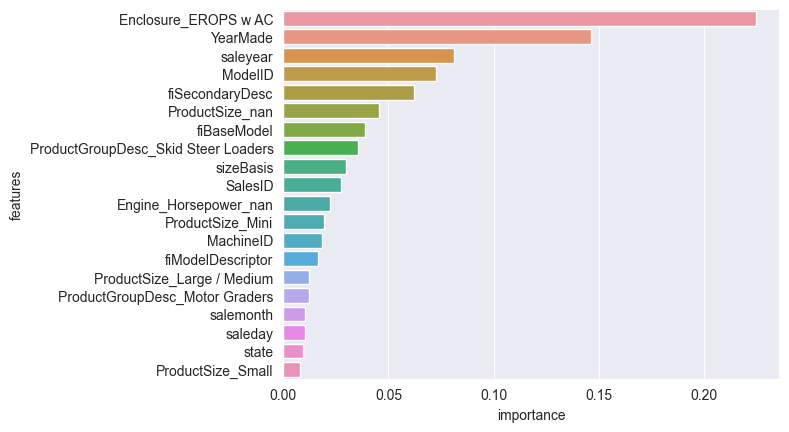

In [54]:
feats = pd.DataFrame({
    'features': X_train.columns,
    'importance': model_tinker.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='features', data=feats[:20], orient='h')